In [148]:
from clip_utils import *
import cv2
import matplotlib.pyplot as plt


def get_image_embeddings(valid_p, valid_l, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_p, valid_l, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    name = []
    for i in range(len(matches)):
        name.append(matches[i].split('/')[-2])
    df = pd.DataFrame(matches)
    df['id']=name
    return df
    


In [5]:
# import required module
import os
# assign directory
directory = '/Users/jihyeonje/Downloads/PDBBind_processed/'

ligpaths = []
protpaths = []

# iterate over files in
# that directory
for dir in os.listdir(directory):
    if dir !='.DS_Store':
        foldr = os.path.join(directory, dir)
    for i in os.listdir(foldr):
        if i.endswith('.sdf'):
            ligpaths.append(os.path.join(foldr, i))
        elif i.endswith('.pdb'):
            protpaths.append(os.path.join(foldr, i))


In [8]:
# import required module
import os
# assign directory
directory = '/Users/jihyeonje/Downloads/PDBBind_processed/'

ligpaths = []
protpaths = []

# iterate over files in
# that directory
for dir in os.listdir(directory):
    if dir !='.DS_Store':
        foldr = os.path.join(directory, dir)
    for i in os.listdir(foldr):
        if i.endswith('.sdf'):
            ligpaths.append(os.path.join(foldr, i))
        elif i.endswith('.pdb'):
            protpaths.append(os.path.join(foldr, i))

In [130]:
ligtxts = []
for k in range(len(ligpaths)):
    suppl = Chem.SDMolSupplier(ligpaths[k], sanitize=False)
    smi = Chem.MolToSmiles(suppl[0])

    ligtxts.append(smi)
    
#protpaths_s = protpaths
#ligtxts_s = ligtxts

In [26]:

train_p, train_l, valid_p, valid_l = make_train_valid_dfs(protpaths_s, ligtxts_s)
#model, image_embeddings = get_image_embeddings(valid_p, valid_l, "best.pt")

In [158]:
import pickle

In [104]:
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
train_loader = build_loaders(valid_p, valid_l, tokenizer, mode="valid")

model = CLIPModel().to(CFG.device)
model.load_state_dict(torch.load("best.pt", map_location=CFG.device))
model.eval()

image_embeddings = []
text_embeddings = []
with torch.no_grad():
    for batch in tqdm(train_loader):
        image_features = model.image_encoder(batch["image"].to(CFG.device))
        image_emb = model.image_projection(image_features).detach().numpy()
        image_embeddings.append(image_emb)

        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_emb = model.text_projection(text_features).detach().numpy()
        text_embeddings.append(text_emb)
        

  0%|          | 0/120 [00:00<?, ?it/s]

In [105]:
ligs =  np.concatenate(text_embeddings)
prots = np.concatenate(image_embeddings)

In [106]:
ligs.shape

(3824, 256)

In [107]:
# Import pandas library 
import pandas as pd 
  

df1 = pd.DataFrame(ligs)
df1['data']=['ligand embedding'] * len(df1)

df2 = pd.DataFrame(prots)
df2['data']=['protein embedding'] * len(df2)

df = pd.concat([df1, df2])

In [152]:
idx = 500
res = find_matches(model, 
             torch.tensor(prots),
             query=ligtxts[idx],
             image_filenames=protpaths,
             n=5)
print(ligpaths[idx])
res

/Users/jihyeonje/Downloads/PDBBind_processed/2azm/2azm_ligand.sdf


,0,id
0,/Users/jihyeonje/Downloads/PDBBind_processed/6...,6nfn
1,/Users/jihyeonje/Downloads/PDBBind_processed/5...,5mty
2,/Users/jihyeonje/Downloads/PDBBind_processed/3...,3ezv
3,/Users/jihyeonje/Downloads/PDBBind_processed/4...,4bkt
4,/Users/jihyeonje/Downloads/PDBBind_processed/5...,5oxm


In [156]:
from pymol import cmd
cmd.load(ligpaths[idx])
cmd.load(res[0][0])

cmd.orient()

# since PyMOL 2.5
cmd.ipython_image()

ModuleNotFoundError: No module named 'pymol'

In [155]:
!conda install jupyter schrodinger::pymol


done
Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::python-language-server==0.31.7=py37_0
  - defaults/osx-64::matplotlib==3.1.3=py37_0
  - defaults/osx-64::pyrsistent==0.15.7=py37h1de35cc_0
  - defaults/osx-64::bokeh==1.4.0=py37_0
  - defaults/osx-64::notebook==6.0.3=py37_0
  - defaults/osx-64::bottleneck==1.3.2=py37h776bbcc_0
  - defaults/osx-64::jupyter==1.0.0=py37_7
  - defaults/osx-64::jupyter_core==4.6.1=py37_0
  - defaults/osx-64::widgetsnbextension==3.5.1=py37_0
  - defaults/noarch::backports.functools_lru_cache==1.6.1=py_0
  - defaults/osx-64::xlwings==0.17.1=py37_0
  - defaults/osx-64::conda-package-handling==1.6.0=py37h1de35cc_0
  - defaults/osx-64::nose==1.3.7=py37_2
  - defaults/noarch::sphinx==2.4.0=py_0
  - defaults/noarch::networkx==2.4=py_0
  - defaults/osx-64::cycler==0.10.0=py37_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/no

In [75]:
import pandas as pd
import numpy as np
import umap

In [129]:
len(ligtxts)

19120

In [125]:
protpaths[50]

'/Users/jihyeonje/Downloads/PDBBind_processed/6o0m/6o0m_protein_processed.pdb'

In [128]:
ligpaths[50]

'/Users/jihyeonje/Downloads/PDBBind_processed/6o0m/6o0m_ligand.sdf'

In [114]:
mapper = umap.UMAP().fit(df2.iloc[:,0:256])


In [83]:
len(df2)

50

/Users/jihyeonje/opt/anaconda3/envs/2020Woo/lib/python3.8/site-packages/umap/plot.py:435: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



<Axes: >

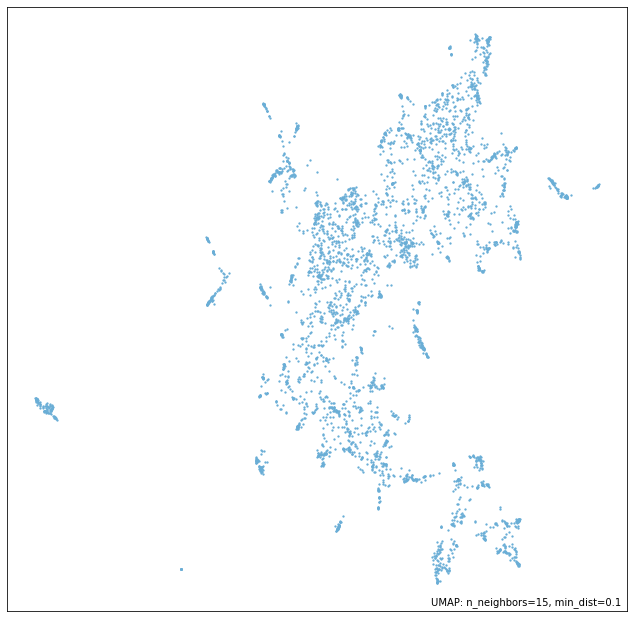

In [115]:
import umap.plot
umap.plot.points(mapper)


In [116]:
from sklearn.decomposition import PCA
import plotly.express as px
pca = PCA(n_components=2)
components = pca.fit_transform(df.iloc[:,0:256])
fig = px.scatter(components, x=0, y=1, color=df['data'])

In [117]:
fig.show()


In [ ]:
import torch
    from torch.nn import CosineSimilarity
    from transformers import CLIPTokenizer, CLIPModel, CLIPTextModel
    cossim = CosineSimilarity(dim=0, eps=1e-6)
    
    def dist(v1, v2):
      return cossim(v1, v2)
    
    torch_device = "cuda" if torch.cuda.is_available() else "cpu"
    
    models = [
        'openai/clip-vit-base-patch16',
        'openai/clip-vit-base-patch32',
        'openai/clip-vit-large-patch14',
    ]
    
    model_id = models[1]
    
    tokenizer = CLIPTokenizer.from_pretrained(model_id)
    text_encoder = CLIPTextModel.from_pretrained(model_id).to(torch_device)
    model = CLIPModel.from_pretrained(model_id).to(torch_device)
    
    prompts = [
      "A cat", "A dog", "A labrador", "A poodle", "A wolf", "A lion", "A house",
    ] 
    
    text_inputs = tokenizer(
        prompts, 
        padding="max_length", 
        return_tensors="pt",
        ).to(torch_device)
    text_features = model.get_text_features(**text_inputs)
    text_embeddings = torch.flatten(text_encoder(text_inputs.input_ids.to(torch_device))['last_hidden_state'],1,-1)
    
    print("\n\nusing text_features")
    for i1, label1 in enumerate(prompts):
      for i2, label2 in enumerate(prompts):
        if (i2>=i1):
          print(f"{label1} <-> {label2} = {dist(text_features[i1], text_features[i2]):.4f}")
    
    print("\n\nusing text_embeddings")
    for i1, label1 in enumerate(prompts):
      for i2, label2 in enumerate(prompts):
        if (i2>=i1):
          print(f"{label1} <-> {label2} = {dist(text_embeddings[i1], text_embeddings[i2]):.4f}")
